## Coursera Machine Learning for Data Analysis
### Week 2 Assignment

#### Intro
I decided to work with a famous dataset - the [Pima Indians Diabetes Database](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.names), which gives you different parameters regarding Indian women's health and medical history, along with a label of having or not having diabetes.<br>
We'll run a random forest classifier to see if we can predict having diabetes from the other health indicators.<br>

We'll do the following:
(click the links to jump to section)
+ [Prepare the data](#data)
+ [Run a Random Forest classifier](#rf)
+ [Look for an optiaml n_estimator value](#n_e)
+ [Examine the feature importance](#feat)


In [ ]:
# I've had issues running matploplib in my virtual env
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics

<a id='data'></a>
### Prepare the data

In [3]:
# Pima Indian Diabetes dataset from the UCI Machine Learning Repository

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv(url, header=None, names=col_names)

print pima.shape

pima.head()

(768, 9)


,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Here is the codebook for the labels, by order of appearance - left to right:<br>
(copied directly from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.names))
1. Number of times pregnant
+ Plasma glucose concentration a 2 hours in an oral glucose tolerance test
+ Diastolic blood pressure (mm Hg)
+ Triceps skin fold thickness (mm)
+ 2-Hour serum insulin (mu U/ml)
+ Body mass index (weight in kg/(height in m)^2)
+ Diabetes pedigree function
+ Age (years)
+ Class variable (0 or 1)


In [4]:
# let's check there are no missing values we need to handle

pima.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnant    768 non-null int64
glucose     768 non-null int64
bp          768 non-null int64
skin        768 non-null int64
insulin     768 non-null int64
bmi         768 non-null float64
pedigree    768 non-null float64
age         768 non-null int64
label       768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


In [5]:
# we can see that for all of the women in the study there are no null values for either parameter. Hooray!

In [6]:
# Some descriptive statistics:

pima.describe()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# And now we'll look at how prevalent diabetes is at the first place.
# This will be useful to examine how well our model is doing.

pima['label'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: label, dtype: float64

We can see that 65% of women do not have diabetes.<br>
What this means is that if we always 'predict' 0 - no diabetes - our prediction would be right **65%** of the time. So, this is **the baseline to beat**.

** Let's do it! **

<a id='rf'></a>
### Running a Random Forest Classifier

In [8]:
# Split to Target and Features
y = pima['label']

# Since 'label' is the last column on the right, we can easily create a list of features like so:
features = col_names[:-1]       # alternatively: list(pima.columns[:-1])
print features

# and use that to get the features DataFrame
X = pima.loc[:, features]
X.head()

['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age']


,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [9]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

print 'There are %d rows and %d columns in the training set.' % (X_train.shape[0], X_train.shape[1])
print 'There are %d rows and %d columns in the test set.' % (X_test.shape[0], X_test.shape[1])
print 'There are %d targets in the training set.' % y_train.shape[0]
print 'There are %d targets in the test set.' % y_test.shape[0]

There are 460 rows and 8 columns in the training set.
There are 308 rows and 8 columns in the test set.
There are 460 targets in the training set.
There are 308 targets in the test set.


In [10]:
# Instantiate the model
model = RandomForestClassifier(criterion='gini', n_estimators=25) 

# fit the model with the training data
model.fit(X_train, y_train)

# and make predictions on the test data
y_pred = model.predict(X_test)

# let's check our accuracy
sklearn.metrics.accuracy_score(y_test, y_pred)

0.72402597402597402

In [11]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[166,  35],
       [ 50,  57]])

In [12]:
for row in sklearn.metrics.classification_report(y_test, y_pred).split('\n\n'):
    print row

             precision    recall  f1-score   support
          0       0.77      0.83      0.80       201
          1       0.62      0.53      0.57       107
avg / total       0.72      0.72      0.72       308



There are two things that are evident from the confusion matrix and the classification report:
1. When the subject _doesn't_ have diabetes, the model does a fairly good job at predicting it. Precision, meaning - when a value is predicted, how often is the prediction correct, is 0.77 and recall - meaning - when the actual value is X, how often is the prediction correct, is 0.83.<br>

+ When the subject _does_ have diabetes, the model does a fair job, but not better than that. Recall is only 0.62 for the True class. This means that when the subject does have diabetes, our model would only predict that 62% of the time. Of the 107 subjects with diabetes in the test set, for only 57 the model predicted diabetes. This goes hand in hand with an f1 score of 0.57. So, overall a C, or a C- I would say.<br>

To sum up, the model does a pretty good job predicting there's no diabetes when there is none indeed (the more common case), but doesn't perform as well predicting diabetes when the subject does have it.

<a id='n_e'></a>
### Searching for an optimal n_estimators

Let's try and find a better value for n_estimators, if there is one.

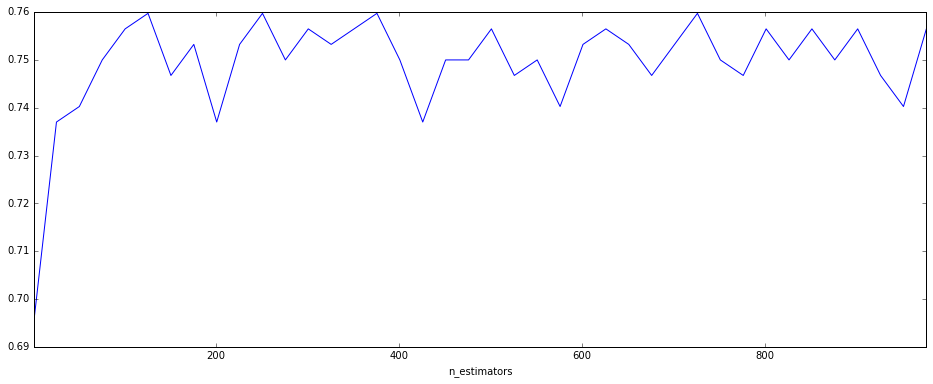

In [13]:
# For that, we'll put the prediction process in a function and run it in a loop for different values of n_estimators.

def run_rfc(n_estimators):
    model = RandomForestClassifier(criterion='gini', n_estimators=n_estimators)

    # fit the model with the training data
    model.fit(X_train, y_train)

    # and make predictions on the test data
    y_pred = model.predict(X_test)

    # let's check our accuracy
    return sklearn.metrics.accuracy_score(y_test, y_pred)


results_d = {}
for i in range(1, 1001, 25):
    results_d[i] = run_rfc(i)
            
    
# We'll make a DataFrame out of the results so it would be easier to plot the accuracy_score by n_estimators
res = pd.DataFrame.from_dict(results_d, orient='index')
res.reset_index(inplace=True)
res.sort_values('index', inplace=True)
res.rename(columns={'index':'n_estimators'}, inplace=True)
res.set_index('n_estimators', inplace=True)

res.plot(legend=False, figsize=(16, 6))

Looks like after n = 100 or so, we do not improve accuracy by using greater n's. We can expect an accuracy of approximately .75 on average.

<a id='feat'></a>
### Feature Importance

Finally, let's examine which features are more and less important for our model.

In [14]:
model1 = ExtraTreesClassifier()
model1.fit(X_train, y_train)

model.feature_importances_

array([ 0.07395009,  0.2719228 ,  0.08758761,  0.06598933,  0.07455717,
        0.17487419,  0.1313316 ,  0.11978722])

In [15]:
feature_importance_df = pd.DataFrame({'feature':features, 'importance':model.feature_importances_})

# Optional, if you want to sort the features by order of importance:
# feature_importance_df.sort_values('importance', ascending=False, inplace=True)

feature_importance_df

,feature,importance
0,pregnant,0.073950
1,glucose,0.271923
2,bp,0.087588
3,skin,0.065989
4,insulin,0.074557
5,bmi,0.174874
6,pedigree,0.131332
7,age,0.119787


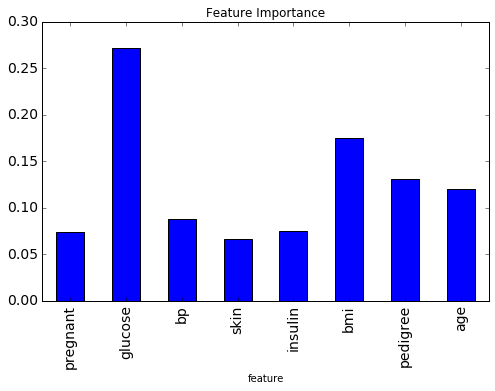

In [16]:
# And life is not worth living without a nice chart
feature_importance_df.set_index('feature').plot(kind='bar', legend=False, 
                                                figsize=(8, 5), fontsize=14, title='Feature Importance')

We can see glucose, bmi, pedigree and age are the most important features, while pregnant, bp, skin and insulin are the least important.

----

### Thank you kind stranger for reading! :)